In [2]:
!nvidia-smi

Wed Apr 13 09:19:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 12.7 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


## Import libraries

In [5]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
from PIL import Image

import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix
import itertools

TensorFlow 1.x selected.
1.15.2


Using TensorFlow backend.


## Download data and unzip

In [6]:
!wget --no-check-certificate \
    https://djangocolab.blob.core.windows.net/aidatacolab2/heart_3_classes_L_147_37.zip\
    -O heart_3_classes_L_147_37.zip

!wget --no-check-certificate \
    https://djangocolab.blob.core.windows.net/aidatacolab2/heart_3_classes_L_test_20220217_J.zip\
    -O heart_3_classes_L_test_20220217_J.zip

--2022-04-13 09:20:25--  https://djangocolab.blob.core.windows.net/aidatacolab2/heart_3_classes_L_147_37.zip
Resolving djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)... 20.150.86.132
Connecting to djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)|20.150.86.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262537 (256K) [application/zip]
Saving to: ‘heart_3_classes_L_147_37.zip’

heart_3_classes_L_1 100%[===================>] 256.38K   277KB/s    in 0.9s    

2022-04-13 09:20:27 (277 KB/s) - ‘heart_3_classes_L_147_37.zip’ saved [262537/262537]

--2022-04-13 09:20:27--  https://djangocolab.blob.core.windows.net/aidatacolab2/heart_3_classes_L_test_20220217_J.zip
Resolving djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)... 20.150.86.132
Connecting to djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)|20.150.86.132|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [7]:
local_zip = 'heart_3_classes_L_147_37.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

local_zip = 'heart_3_classes_L_test_20220217_J.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

!rm -r __MACOSX
# !rm heart_3_classes_L_147_37/test/*/.DS*
# !rm heart_3_classes_L_147_37/train/inferior/.DS*

In [8]:
train_root = os.path.join("heart_3_classes_L_147_37", "train")
test_root = os.path.join("heart_3_classes_L_147_37", "test")
ev_root = os.path.join("heart_3_classes_L_test_20220217_J", "test")

train_folders = [i for i in os.listdir(train_root) if not i.startswith('.')]
test_folders = [i for i in os.listdir(test_root) if not i.startswith('.')]
ev_folders = [i for i in os.listdir(ev_root) if not i.startswith('.')]

train_count = 0
test_count = 0
ev_count = 0

for f in train_folders:
  files = [i for i in os.listdir(os.path.join(train_root, f)) if not i.startswith('.')]
  print(len(files), "images in folder '", f, "'")
  train_count = train_count + len(files)
print("***", train_count, "training images")

for f in test_folders:
  files = [i for i in os.listdir(os.path.join(test_root, f)) if not i.startswith('.')]
  print(len(files), "images in folder '", f, "'")
  test_count = test_count + len(files)
print("***", test_count, "testing images")

for f in ev_folders:
  files = [i for i in os.listdir(os.path.join(ev_root, f)) if not i.startswith('.')]
  print(len(files), "images in folder '", f, "'")
  ev_count = ev_count + len(files)
print("***", ev_count, "EV images")

56 images in folder ' Normal '
71 images in folder ' Septal '
20 images in folder ' Posterolateral '
*** 147 training images
14 images in folder ' Normal '
18 images in folder ' Septal '
5 images in folder ' Posterolateral '
*** 37 testing images
51 images in folder ' Normal '
26 images in folder ' Septal '
12 images in folder ' Posterolateral '
*** 89 EV images


heart_3_classes_L_147_37/train/Posterolateral/C4041_l.png
(256, 256)


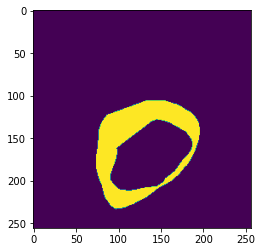

heart_3_classes_L_147_37/train/Posterolateral/yk0064 hypo 4,5_combined_l.png
(256, 256)


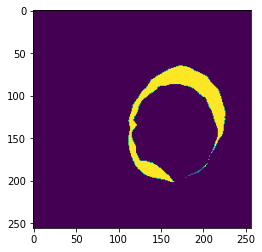

In [9]:
pic_index = 2
target_folder = "Posterolateral"

files = [i for i in os.listdir(os.path.join(train_root, target_folder)) if not i.startswith('.')]
next_files = [os.path.join(train_root, target_folder, f) for f in files[0:pic_index]]
for i, img_path in enumerate(next_files):
  print(img_path)
  img = mpimg.imread(img_path)
  print(img.shape)
  plt.imshow(img)
  plt.show()

## Utils

In [10]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Reds):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    #plt.ylim([4.5, -0.5]) # solve squished issue

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix!")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i , cm[i, j],
                horizontalalignment = "center",
                color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
def calculate_acc(cm):
  total = 0
  ok = 0
  row, col = cm.shape
  for i in range(row):
    for j in range(col):
      if i == j:
        total = total + cm[i,j]
        ok = ok + cm[i,j]
      else:
        total = total + cm[i,j]
  return print("accuracy:", round(ok/total,3))

def calculate_metrics(cm):
  FP = cm.sum(axis=0) - np.diag(cm) 
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)
  TN = cm.sum() - (FP + FN + TP)
  # Sensitivity, recall, or true positive rate
  TPR = TP/(TP+FN)
  print("Sensitivity/Recall for each class:", np.round(TPR,2))
  print("Sensitivity/Recall:", round(np.mean(TPR),3))
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  print("Specificity for each class:", np.round(TNR,2))
  print("Specificity:", round(np.mean(TNR),3))
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  print("Precision for each class:", np.round(PPV,2))
  print("Precision:", round(np.mean(PPV),3))

  # # Overall accuracy for each class
  # ACC = (TP+TN)/(TP+FP+FN+TN)
  # print("Accuracy for each class:", ACC)
  # print("Accuracy:", round(np.mean(ACC),3))

  # # recall(sensitivity)
  # recall = np.diag(cm) / np.sum(cm, axis = 1)
  # #precision
  # precision = np.diag(cm) / np.sum(cm, axis = 0)

https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872  
https://stats.stackexchange.com/questions/51296/how-do-you-calculate-precision-and-recall-for-multiclass-classification-using-co  

## Data augmentation

In [11]:
width = 256
height = 256
bs_train = 8
bs_test = 1

gobj = ImageDataGenerator(# validation_split=0.2, #use fewer training data in this transfer learning case on purpose
    rescale=1./255, 
    rotation_range=20,     
    width_shift_range=0.05,  
    height_shift_range=0.05, 
    shear_range=10,         
    zoom_range=0.05,        
    horizontal_flip=False
    )  # 

trn_gen = gobj.flow_from_directory( 
    train_root,         
    target_size=(width, height),  
    batch_size=bs_train,        
    class_mode='sparse',    
    subset='training')

gobj = ImageDataGenerator(rescale=1./255) #

val_gen = gobj.flow_from_directory( 
    test_root,          
    target_size=(width, height),
    batch_size=bs_test,
    class_mode='sparse') 

gobj = ImageDataGenerator(rescale=1./255) #

ev_gen = gobj.flow_from_directory( 
    ev_root,          
    target_size=(width, height),
    batch_size=bs_test,
    class_mode='sparse')       

Found 147 images belonging to 3 classes.
Found 37 images belonging to 3 classes.
Found 89 images belonging to 3 classes.


In [12]:
# make sure two dictionaries are the same
labels = (trn_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
labels = (val_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
labels = (ev_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'Normal', 1: 'Posterolateral', 2: 'Septal'}
{0: 'Normal', 1: 'Posterolateral', 2: 'Septal'}
{0: 'Normal', 1: 'Posterolateral', 2: 'Septal'}


image shape: (256, 256, 3)
the ground truth label: Normal


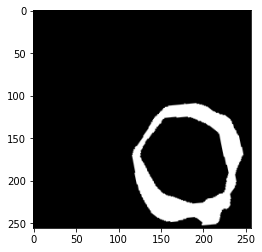

image shape: (256, 256, 3)
the ground truth label: Septal


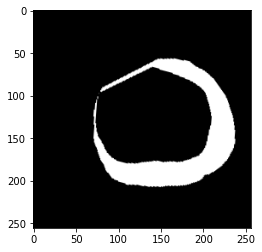

image shape: (256, 256, 3)
the ground truth label: Septal


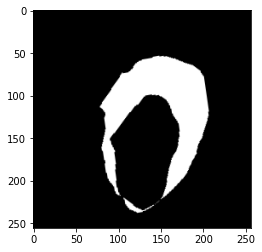

In [13]:
x,y = trn_gen.next()
for i in range(3):
    img = x[i]
    print("image shape:", img.shape)
    label = y[i]
    print("the ground truth label:", labels[label])
    plt.imshow(img)
    plt.show()

## Build the model

In [15]:
model = Sequential()
model.add(Conv2D(16,input_shape=(width,height,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(3,activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', 
              metrics=['acc'],
              optimizer=tf.keras.optimizers.Adam(lr=0.001))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)      

## Train the model

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/colab_data/chimei_2_views/checkpoints/Classification/custom_102_3_classes_{epoch:02d}_{val_acc:.2f}.h5',
                                    save_best_only=True, monitor='val_acc', mode='max'), # save_weights_only=True, 
    tf.keras.callbacks.ReduceLROnPlateau(patience=20, verbose=1),
]

history = model.fit(trn_gen,        
                    epochs=200, verbose=1,
                    validation_data=val_gen,
                    callbacks=callbacks,)

tf.keras.models.save_model(model, 'drive/MyDrive/colab_data/chimei_2_views/checkpoints/Classification/custom_102_3_classes_200.h5')

Epoch 1/200
13/13 [==============================] - 4s 317ms/step - loss: 1.0896 - acc: 0.4314 - val_loss: 1.0826 - val_acc: 0.4167
Epoch 2/200
13/13 [==============================] - 1s 98ms/step - loss: 1.0810 - acc: 0.4314 - val_loss: 1.0786 - val_acc: 0.4167
Epoch 3/200
13/13 [==============================] - 1s 106ms/step - loss: 1.0690 - acc: 0.4314 - val_loss: 1.0780 - val_acc: 0.4167
Epoch 4/200
13/13 [==============================] - 1s 104ms/step - loss: 1.0668 - acc: 0.4314 - val_loss: 1.0783 - val_acc: 0.4167
Epoch 5/200
13/13 [==============================] - 1s 103ms/step - loss: 1.0705 - acc: 0.4314 - val_loss: 1.0659 - val_acc: 0.4167
Epoch 6/200
13/13 [==============================] - 1s 103ms/step - loss: 1.0640 - acc: 0.4314 - val_loss: 1.0697 - val_acc: 0.4167
Epoch 7/200
13/13 [==============================] - 1s 104ms/step - loss: 1.0684 - acc: 0.4314 - val_loss: 1.0633 - val_acc: 0.4167
Epoch 8/200
13/13 [==============================] - 1s 106ms/step - l

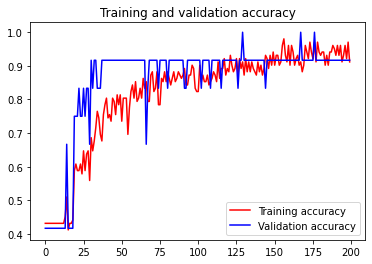

<Figure size 432x288 with 0 Axes>

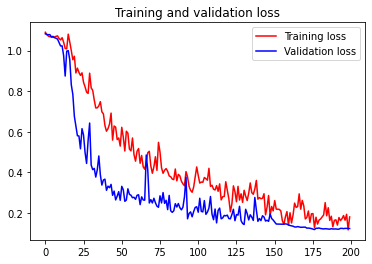

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Save / Load model

In [16]:
# model.save("drive/MyDrive/colab_data/chimei_2_views/checkpoints/Classification/custom_102_3_classes.h5")

model = tf.keras.models.load_model('drive/MyDrive/colab_data/chimei_2_views/checkpoints/Classification/20211209_147_custom_lateral/custom_147_3_classes_53_0.95.h5')
# model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
# model.compile(loss='sparse_categorical_crossentropy', 
#               metrics=['acc',tf.keras.metrics.AUC()],
#               optimizer=tf.keras.optimizers.Adam(lr=0.001))

# scores = model.evaluate_generator(val_gen)
# print(scores)
# print("Loss: {:.4}".format(scores[0]))
# print("Accuracy: {:.4}".format(scores[1]))
# print("AUC: {:.4}".format(scores[2]))

# scores = model.evaluate_generator(ev_gen)
# print(scores)
# print("Loss: {:.4}".format(scores[0]))
# print("Accuracy: {:.4}".format(scores[1]))
# print("AUC: {:.4}".format(scores[2]))

[0.27115251703857995, 0.9459459, 0.48205656]
Loss: 0.2712
Accuracy: 0.9459
AUC: 0.4821
[0.24867870606085693, 0.9325843, 0.5288098]
Loss: 0.2487
Accuracy: 0.9326
AUC: 0.5288


## Confusion matrix

### Validation

37
[1. 0. 2. 0. 1. 2. 0. 2. 2. 2. 2. 0. 2. 2. 2. 0. 2. 0. 0. 2. 0. 0. 0. 2.
 2. 2. 1. 1. 2. 0. 0. 0. 1. 2. 0. 2. 2.]
[1. 0. 2. 0. 1. 2. 0. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 0. 0. 2. 0. 0. 0. 2.
 2. 2. 1. 1. 2. 0. 0. 0. 0. 2. 0. 2. 2.]
Confusion matrix, without normalization
[[13  0  1]
 [ 1  4  0]
 [ 0  0 18]]
Sensitivity/Recall for each class: [0.93 0.8  1.  ]
Sensitivity/Recall: 0.91
Specificity for each class: [0.96 1.   0.95]
Specificity: 0.968
Precision for each class: [0.93 1.   0.95]
Precision: 0.959
accuracy: 0.946


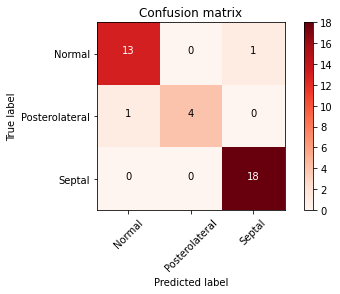

In [22]:
y_true = np.array([])
y_pred = np.array([])

for step in range(int(test_count/bs_test)): # test_count/bs_test  ev_count/bs_test
  X,y = val_gen.next() # val_gen / ev_gen
  y_true = np.append(y_true, y)
  result = model.predict(X)
  result = np.argmax(result, axis=1)
  y_pred = np.append(y_pred, result)

print(len(y_pred))
print(y_true)
print(y_pred)

# get the label name list
cm_plot_labels = []
for i in range(3):
  cm_plot_labels.append(labels[i])
  # print(i, labels[i])
# get cm
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, cm_plot_labels)

# metrics
calculate_metrics(cm)
calculate_acc(cm)

### Test

89
[2. 2. 0. 0. 2. 0. 0. 1. 2. 0. 1. 1. 0. 2. 0. 2. 0. 1. 0. 0. 0. 1. 2. 0.
 0. 0. 2. 2. 1. 2. 2. 2. 2. 0. 2. 0. 0. 2. 2. 1. 2. 0. 0. 0. 1. 0. 2. 1.
 2. 2. 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.
 0. 0. 2. 0. 0. 1. 0. 0. 2. 0. 0. 1. 1. 0. 0. 0. 0.]
[2. 2. 0. 0. 2. 0. 0. 1. 0. 0. 1. 1. 0. 2. 0. 2. 0. 2. 0. 0. 0. 1. 2. 0.
 0. 2. 2. 2. 1. 2. 2. 2. 2. 0. 2. 0. 0. 2. 2. 0. 2. 0. 0. 0. 1. 0. 2. 1.
 2. 2. 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.
 0. 0. 2. 0. 0. 2. 0. 0. 2. 0. 0. 1. 1. 0. 0. 1. 0.]
Confusion matrix, without normalization
[[49  1  1]
 [ 1  9  2]
 [ 1  0 25]]
Sensitivity/Recall for each class: [0.96 0.75 0.96]
Sensitivity/Recall: 0.891
Specificity for each class: [0.95 0.99 0.95]
Specificity: 0.962
Precision for each class: [0.96 0.9  0.89]
Precision: 0.918
accuracy: 0.933


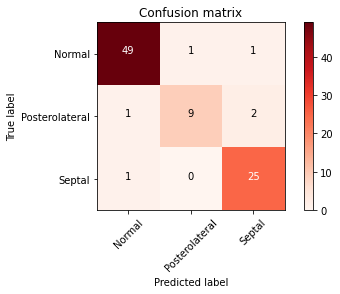

In [23]:
y_true = np.array([])
y_pred = np.array([])

for step in range(int(ev_count/bs_test)): # test_count/bs_test  ev_count/bs_test
  X,y = ev_gen.next() # val_gen / ev_gen
  y_true = np.append(y_true, y)
  result = model.predict(X)
  result = np.argmax(result, axis=1)
  y_pred = np.append(y_pred, result)

print(len(y_pred))
print(y_true)
print(y_pred)

# get the label name list
cm_plot_labels = []
for i in range(3):
  cm_plot_labels.append(labels[i])
  # print(i, labels[i])
# get cm
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, cm_plot_labels)

# metrics
calculate_metrics(cm)
calculate_acc(cm)

## CAM model

In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
print(gap_weights.shape)

cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

(128, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)     

In [ ]:
def show_cam(image_value, features, results, level, width, height, last_conv_size, cmap = cv2.COLORMAP_JET):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300 (256)
    features (array) -- features of the image, shape (1, 37, 37, 128)     (32)
    results (array) -- output of the sigmoid layer
    level (string) -- hypokinesia or akinesia
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]
  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]
  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (width/last_conv_size, height/last_conv_size, 1), order=2)
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  # visualize the results
  print(f'predicted output: {results}')
  print("the predict result is:", labels[np.argmax(results[0])])
  if labels[np.argmax(results[0])] != "Normal":
    print(f'hypokinesia / akinesia / dyskinesia: {level}')
  cam_output = Image.fromarray(cam_output).convert('RGB')
  cam_output.save("cam.jpg")
  cam_output = cv2.imread("cam.jpg")
  cam_output = cv2.applyColorMap(cam_output, cmap)
  image_value = np.squeeze(image_value).astype(np.uint8) * 255
  combined = cv2.addWeighted(cam_output,1,image_value,1,0)
  cv2.imwrite("combined.jpg" , combined)
  cv2_imshow(combined)


def check_HAD(img, dys_threshold=30000, aki_threshold=250):
  """
  check if the donut is Hypokinesia, Akinesia, or Dyskinesia
  Args:
    img: cv2 np array image
    dys_threshold: pixel count threshold to be dyskinesia
    aki_threshold: contour point threshold to be akinesia
    level: string
  """
  ### remove max and min value in img ###
  np_temp = np.where(img == np.max(img), 0, img)
  np_temp = np.where(np_temp == np.min(img), 0, np_temp)
  print("gray area pixel count:", np.sum(np_temp))
  if np.sum(np_temp) > dys_threshold:
    level = "Dyskinesia"
  else:
    img_temp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(img_temp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_temp, contours, -1, (100), 2)
    cv2_imshow(img_temp)
    print("len(contours):", len(contours))
    count = 2
    for c in contours:
      print("contours lenth:", len(c))
      if len(c) > aki_threshold:
        count = count - 1
    if count <= 0:
      level = "Hypokinesia"
    else:
      level = "Akinesia"
  return level


# utility function to preprocess an image and show the CAM
def convert_and_classify(image, width, height, last_conv_size, cmap=cv2.COLORMAP_JET):
  # load the image
  img = cv2.imread(image)
  level = check_HAD(img)
  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (width, height)) / 255.0
  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)
  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  # generate the CAM
  show_cam(tensor_image, features, results, level, width, height, last_conv_size, cmap)

color map: https://learnopencv.com/applycolormap-for-pseudocoloring-in-opencv-c-python/  

## Test the model

gray area pixel count: 0


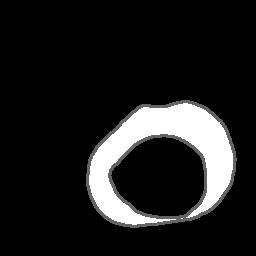

len(contours): 2
contours lenth: 390
contours lenth: 252
predicted output: [[0.4901728  0.5035678  0.00625939]]
the predict result is: Posterolateral
hypokinesia / akinesia / dyskinesia: Hypokinesia


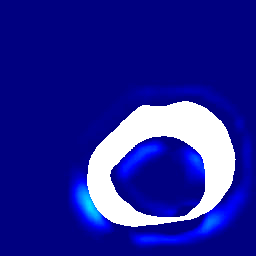

In [ ]:
width, height = 256,256
last_conv_size = 32

# Normal
# path = "./heart_3_classes_L_147_37/test/Normal/yk0120 hypo3_combined_l.png"
# path = "./heart_3_classes_L_147_37/test/Normal/yk0073 hypo2,3,4,6_l.png"

# Posterolateral
# path = "./heart_3_classes_L_147_37/test/Posterolateral/C3932_combined_l.png"
path = "./heart_3_classes_L_102_12_0127/test/Posterolateral/C5183 inferior hypo_combined_l.png" 

# Septal
# path = "./heart_3_classes_L_147_37/test/Septal/C2819 ant hypo_l.png"
# path = "./heart_3_classes_L_147_37/test/Septal/C2982 ant hypo_combined_l.png" 
# path = "./heart_3_classes_L_147_37/test/Septal/C4258_l.png" 


convert_and_classify(path, width, height, last_conv_size)

### Find the wrong prediction case

In [ ]:
### {0: 'Normal', 1: 'Posterolateral', 2: 'Septal'}
find_k = 2

test_files = [i for i in os.listdir(os.path.join(ev_root, labels[find_k])) if not i.startswith('.')]

for f in test_files:
  # load the image
  img = cv2.imread(os.path.join(ev_root, labels[find_k], f))
  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (width, height)) / 255.0
  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)
  # get the prediction
  result = model.predict(tensor_image)
  result = np.argmax(result, axis=1)
  
  if result != find_k:
    print(result, f)

[0] 11102343_combined_l.png


Reference:  
https://github.com/qubvel/efficientnet/blob/master/examples/inference_example.ipynb  
https://www.tensorflow.org/tutorials/images/transfer_learning  
https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB3  
https://github.com/tensorflow/tensorflow/issues/37680  
https://github.com/ismailuddin/gradcam-tensorflow-2/blob/master/notebooks/GradCam.ipynb  